## **Evaluator-Optimizer Workflow**


In [1]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Pydantic schema
class llm_schema(BaseModel):
    funny_flag: Literal["funny", "not funny"] = Field(
        description="Whether the joke is funny or not")

    feedback: str = Field(description="Feedback on the joke")

In [3]:
llm = ChatGroq(model="llama-3.1-8b-instant")

schema_llm = llm.with_structured_output(llm_schema)

In [4]:
# graph schema
class graph_schema(TypedDict):

    topic: str
    joke: str
    funny_flag: str
    feedback: str
    max_iterations: int

In [5]:
# Nodes

def generate_node(state: graph_schema) -> graph_schema:

    topic = state['topic']

    if state['feedback']:  # Not first iteration, generate a joke based on feedback
        response = llm.invoke(
            f"Please modify the following joke {state['joke']} based on the following feedback: {state['feedback']}")

    else:  # First iteration, generate a joke
        response = llm.invoke(
            "Create only one joke about the following topic: " + topic)

    state['joke'] = response.content
    return state


def evaluate_node(state: graph_schema) -> graph_schema:

    joke = state['joke']
    iteration = state['max_iterations']

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a comedy critic. Your job is to evaluate the following joke and provide feedback on how to make it funnier."),
        ("user",
         f"Evaluate the following joke: {joke}\nRespond with 'funny' or 'not_funny' and provide feedback if it's not funny.")
    ])

    chain = prompt | schema_llm
    response = chain.invoke({"joke": joke})

    state['funny_flag'] = response.funny_flag
    state['feedback'] = response.feedback

    state['max_iterations'] += 1

    return state

In [6]:
# conditional edge
def check_iteration(state: graph_schema) -> str:

    iteration = state['max_iterations']

    if iteration <= 5 and state['funny_flag'] != "funny":
        return "evaluate_node"
    else:
        return "end"

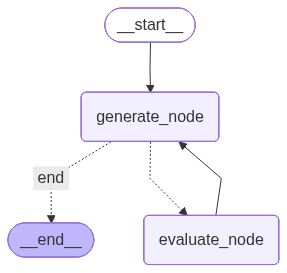

In [7]:
# building graph
graph = StateGraph(graph_schema)

graph.add_node("generate_node", generate_node)
graph.add_node("evaluate_node", evaluate_node)

graph.add_edge(START, "generate_node")

graph.add_conditional_edges("generate_node", check_iteration,
                            {
                                "evaluate_node": "evaluate_node", "end": END
                            }
                            )

graph.add_edge("evaluate_node", "generate_node")
graph.add_edge("generate_node", END)

evaluator_graph = graph.compile()
evaluator_graph

In [8]:
for chunk in evaluator_graph.stream(
    {
        "topic": "Cars",
        "joke": "",
        "funny_flag": "",
        "feedback": "",
        "max_iterations": 0
    },
    stream_mode="updates"
):
    print(chunk)

{'generate_node': {'topic': 'Cars', 'joke': 'Why did the car go to the party? \n\nBecause it was a "wheel" good time.', 'funny_flag': '', 'feedback': '', 'max_iterations': 0}}
{'evaluate_node': {'topic': 'Cars', 'joke': 'Why did the car go to the party? \n\nBecause it was a "wheel" good time.', 'funny_flag': 'funny', 'feedback': "The joke is funny because it uses a play on words, 'wheel' instead of 'wheel good', to create a pun. It's a clever and unexpected twist that adds to the humor.", 'max_iterations': 1}}
{'generate_node': {'topic': 'Cars', 'joke': 'To modify the joke while maintaining its core structure and pun, here are a few options:\n\n1. Why did the bicycle go to the party? \nBecause it was a "wheel" good time.\n\nThis variation replaces the car with a bicycle, which still has wheels, maintaining the pun\'s relevance.\n\n2. Why did the spaceship go to the party? \nBecause it was a "wheel" good time.\n\nThis option replaces the car with a spaceship, which has wheels or wheel-l

In [9]:
print(chunk["generate_node"]["joke"])

To modify the joke while maintaining its core structure and pun, here are a few options:

1. Why did the bicycle go to the party? 
Because it was a "wheel" good time.

This variation replaces the car with a bicycle, which still has wheels, maintaining the pun's relevance.

2. Why did the spaceship go to the party? 
Because it was a "wheel" good time.

This option replaces the car with a spaceship, which has wheels or wheel-like structures, and the pun still works.

3. Why did the skateboard go to the party? 
Because it was a "wheel" good time.

This variation replaces the car with a skateboard, which has wheels, and the pun remains effective.

4. Why did the motorcycle go to the party? 
Because it was a "wheel" good time.

This option keeps the car theme but replaces it with a motorcycle, which also has wheels, maintaining the pun's coherence.

5. Why did the toy car go to the party? 
Because it was a "wheel" good time.

This variation maintains the car theme but gives it a more playfu